In [1]:
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean

## 1. Train, Validation, Test dataset 개별적으로 생성



In [2]:
n_train, n_validation, n_test = 1000, 300, 300

train_x = np.random.normal(0, 1, size=(n_train, 1)).astype(np.float32)
train_x_noise = train_x + 0.2*np.random.normal(0, 1, size=(n_train, 1))
train_y = (train_x_noise > 0).astype(np.int32)

validation_x = np.random.normal(0, 1, size=(n_validation, 1)).astype(np.float32)
validation_x_noise = validation_x + 0.2*np.random.normal(0, 1, size=(n_validation, 1))
validation_y = (validation_x_noise > 0).astype(np.int32)

test_x = np.random.normal(0, 1, size=(n_test, 1)).astype(np.float32)
test_x_noise = test_x + 0.2*np.random.normal(0, 1, size=(n_test, 1))
test_y = (test_x_noise > 0).astype(np.int32)

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(n_train).batch(8)

validation_ds = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))
validation_ds = validation_ds.batch(8)

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.batch(n_validation)

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.batch(n_test)

## 2. Validation, Test 로직 추가하여 모델 구현

In [6]:
model = Sequential()
model.add(Dense(units=2, activation='softmax'))

loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate=1)

train_loss = Mean()
train_acc = SparseCategoricalAccuracy()

validation_loss = Mean()
validation_acc = SparseCategoricalAccuracy()

test_loss = Mean()
test_acc = SparseCategoricalAccuracy()

In [7]:
EPOCHS = 10

train_losses, validation_losses = [], []
train_accs, validation_accs = [], []
for epoch in range(EPOCHS):
    for x, y in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(y, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_acc(y, predictions)

    for x, y in validation_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)
        
        validation_loss(loss)
        validation_acc(y, predictions)

    print(colored('Epoch: ', 'red', 'on_white'), epoch + 1)
    template = 'Train Loss: {:.4f}\t Train Accuracy: {:.2f}% \n' + \
        'Validation Loss: {:.4f}\t Validation Accuracy: {:.2f}% \n'
    print(template.format(train_loss.result(), train_acc.result()*100,
                          validation_loss.result(), validation_acc.result()*100))
    train_losses.append(train_loss.result())
    validation_losses.append(validation_loss.result())
    train_accs.append(train_acc.result()*100)
    validation_accs.append(validation_acc.result()*100)

    train_loss.reset_states()   # Epoch를 한 번 돌 때마다 reset해 준다
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()

for x, y in test_ds:
    predictions = model(x)
    loss = loss_object(y, predictions)
    
    test_loss(loss)
    test_acc(y, predictions)

print(colored('Final Result: ', 'cyan', 'on_white'))
template = 'Test Loss: {:.4f}\t Test Accuracy: {:.2f}% \n'
print(template.format(test_loss.result(), test_acc.result()*100))

Epoch:  1
Train Loss: 0.4675	 Train Accuracy: 67.50% 
Validation Loss: 0.3194	 Validation Accuracy: 92.00% 

Epoch:  2
Train Loss: 0.2832	 Train Accuracy: 93.10% 
Validation Loss: 0.2658	 Validation Accuracy: 92.00% 

Epoch:  3
Train Loss: 0.2421	 Train Accuracy: 93.00% 
Validation Loss: 0.2406	 Validation Accuracy: 92.00% 

Epoch:  4
Train Loss: 0.2210	 Train Accuracy: 93.00% 
Validation Loss: 0.2254	 Validation Accuracy: 92.00% 

Epoch:  5
Train Loss: 0.2076	 Train Accuracy: 93.10% 
Validation Loss: 0.2150	 Validation Accuracy: 92.00% 

Epoch:  6
Train Loss: 0.1983	 Train Accuracy: 93.10% 
Validation Loss: 0.2073	 Validation Accuracy: 92.00% 

Epoch:  7
Train Loss: 0.1914	 Train Accuracy: 93.10% 
Validation Loss: 0.2015	 Validation Accuracy: 92.00% 

Epoch:  8
Train Loss: 0.1860	 Train Accuracy: 93.10% 
Validation Loss: 0.1968	 Validation Accuracy: 92.00% 

Epoch:  9
Train Loss: 0.1817	 Train Accuracy: 93.30% 
Validation Loss: 0.1931	 Validation Accuracy: 92.33% 

Epoch:  10
Train Lo

## 3. 함수로 모듈화 + @tf.function 적용

@tf.function을 적용할 경우, 좀 더 학습이 빨라짐  
(단, 디버깅 시에는 붙이지 않는게 적절함)

In [12]:
@tf.function
def train_step(x, y):
    global model, loss_object
    global train_loss, train_acc

    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(y, predictions)

@tf.function
def validation():
    global validation_ds, model, loss_object
    global validation_loss, validation_acc

    for x, y in validation_ds:
        predictions = model(x)
        loss = loss_object(y, predictions)
        
        validation_loss(loss)
        validation_acc(y, predictions)

def train_reporter():
    global epoch
    global train_loss, train_acc
    global validation_loss, validation_acc

    print(colored('Epoch: ', 'red', 'on_white'), epoch + 1)
    template = 'Train Loss: {:.4f}\t Train Accuracy: {:.2f}% \n' + \
        'Validation Loss: {:.4f}\t Validation Accuracy: {:.2f}% \n'
    print(template.format(train_loss.result(), train_acc.result()*100,
                          validation_loss.result(), validation_acc.result()*100))

def metric_resetter():
    global train_loss, train_acc
    global validation_loss, validation_acc

    train_losses.append(train_loss.result())
    validation_losses.append(validation_loss.result())
    train_accs.append(train_acc.result()*100)
    validation_accs.append(validation_acc.result()*100)

    train_loss.reset_states()   # Epoch를 한 번 돌때마다 reset해 준다
    train_acc.reset_states()
    validation_loss.reset_states()
    validation_acc.reset_states()

def final_result_visualization():
    global train_losses, validation_losses
    global train_accs, validation_accs

    fig, axes = plt.subplots(2, 1, figsize=(20, 15))
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(validation_losses, label="Validation Loss")
    axes[0].tick_params(labelsize=20)
    axes[0].set_ylabel('Binary CrossEntropy', fontsize=20)
    axes[0].legend(loc='upper right', fontsize=20)

    axes[1].plot(train_accs, label="Train Accuracy")
    axes[1].plot(validation_accs, label="Validation Accuracy")
    axes[1].tick_params(labelsize=20)
    axes[1].set_ylabel('Accuracy', fontsize=20)
    axes[1].set_xlabel('Epoch', fontsize=20)
    axes[1].legend(loc='lower right', fontsize=20)


Epoch:  1
Train Loss: 0.3958	 Train Accuracy: 93.30% 
Validation Loss: 0.3074	 Validation Accuracy: 92.00% 

Epoch:  2
Train Loss: 0.2746	 Train Accuracy: 93.10% 
Validation Loss: 0.2610	 Validation Accuracy: 92.00% 

Epoch:  3
Train Loss: 0.2382	 Train Accuracy: 93.00% 
Validation Loss: 0.2379	 Validation Accuracy: 92.00% 

Epoch:  4
Train Loss: 0.2186	 Train Accuracy: 93.10% 
Validation Loss: 0.2236	 Validation Accuracy: 92.00% 

Epoch:  5
Train Loss: 0.2060	 Train Accuracy: 93.10% 
Validation Loss: 0.2137	 Validation Accuracy: 92.00% 

Epoch:  6
Train Loss: 0.1971	 Train Accuracy: 93.10% 
Validation Loss: 0.2064	 Validation Accuracy: 92.00% 

Epoch:  7
Train Loss: 0.1905	 Train Accuracy: 93.10% 
Validation Loss: 0.2007	 Validation Accuracy: 92.00% 

Epoch:  8
Train Loss: 0.1853	 Train Accuracy: 93.20% 
Validation Loss: 0.1962	 Validation Accuracy: 92.00% 

Epoch:  9
Train Loss: 0.1811	 Train Accuracy: 93.30% 
Validation Loss: 0.1926	 Validation Accuracy: 92.33% 

Epoch:  10
Train Lo

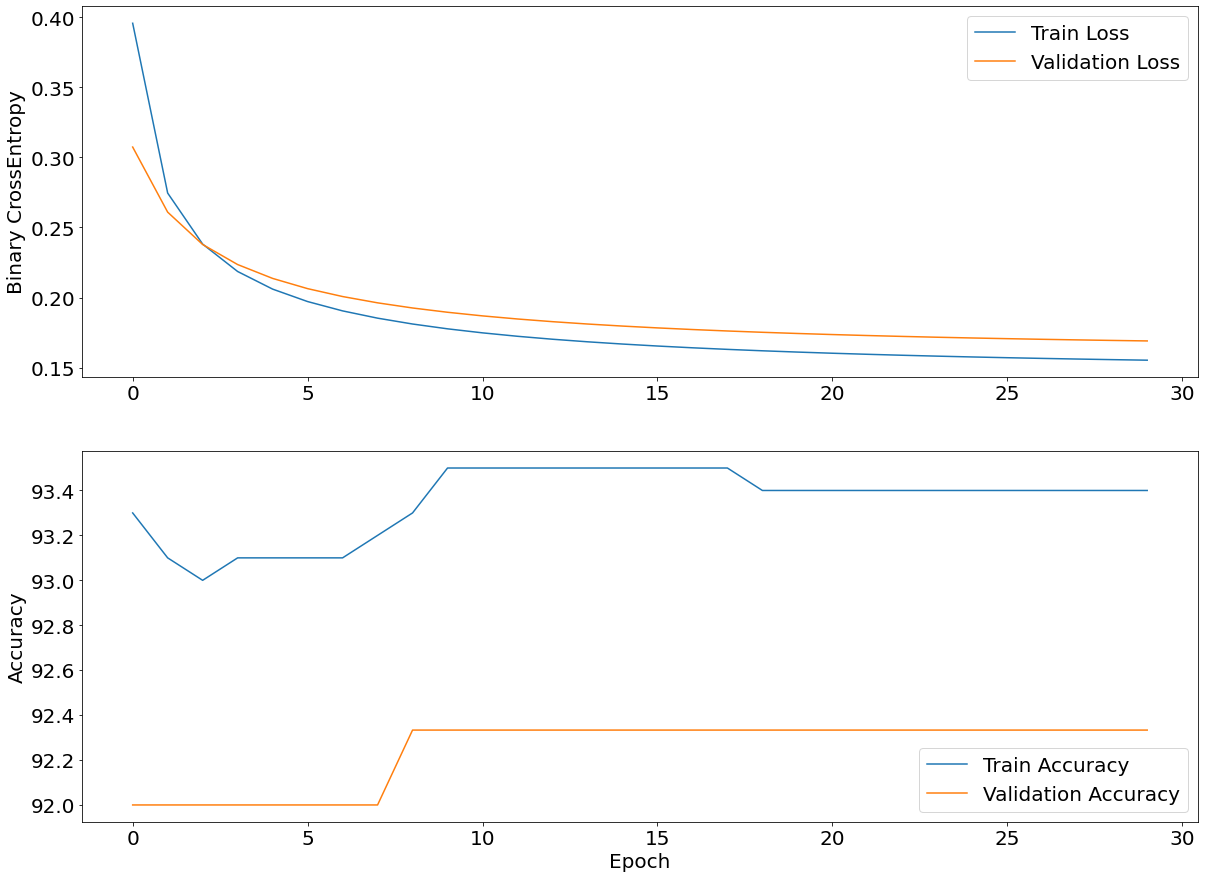

In [13]:
EPOCHS = 30

model = Sequential()
model.add(Dense(units=2, activation='softmax'))
loss_object = SparseCategoricalCrossentropy()
optimizer = SGD(learning_rate=1)
train_loss = Mean()
train_acc = SparseCategoricalAccuracy()
validation_loss = Mean()
validation_acc = SparseCategoricalAccuracy()
test_loss = Mean()
test_acc = SparseCategoricalAccuracy()

train_losses, validation_losses = [], []
train_accs, validation_accs = [], []
for epoch in range(EPOCHS):
    for x, y in train_ds:
        train_step(x, y)

    validation()
    train_reporter()
    metric_resetter()


for x, y in test_ds:
    predictions = model(x)
    loss = loss_object(y, predictions)
    
    test_loss(loss)
    test_acc(y, predictions)

print(colored('Final Result: ', 'cyan', 'on_white'))
template = 'Test Loss: {:.4f}\t Test Accuracy: {:.2f}% \n'
print(template.format(test_loss.result(), test_acc.result()*100))


final_result_visualization()